In [28]:
# Nora Nickels
# MACS POCM Winter 2018
# HW 2

# Please bear with me this is my first time using python and I apologize for the ugliness of this ...
# R I miss you already

import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt

# This next command is specifically for Jupyter Notebook
%matplotlib notebook

# 1. Some income data, lognormal distribution, and hypothesis testing (6 points)

# Load incomes data
incomes = np.loadtxt('incomes.txt')

<IPython.core.display.Javascript object>


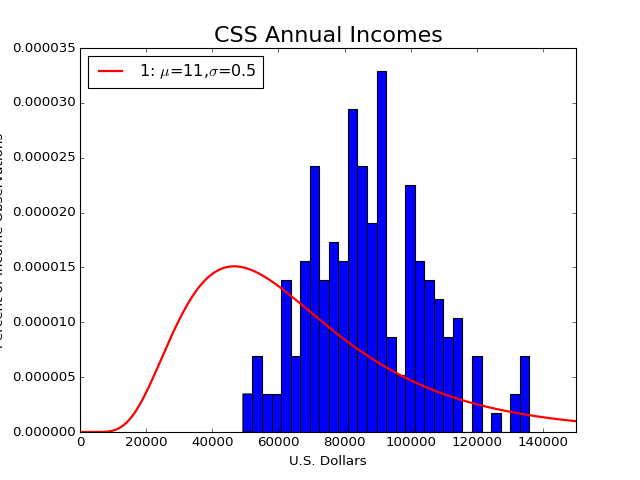

(0, 150000)

In [3]:
# a. Plot histogram 
count, bins, ignored = plt.hist(incomes, 30, edgecolor='black', normed=True)
plt.title('CSS Annual Incomes', fontsize=20)
plt.xlabel('U.S. Dollars')
plt.ylabel('Percent of Income Observations')
plt.xlim([0, 150000])  # This gives the xmin and xmax to be plotted"
# Don't set this figure until have played with the figure below

In [5]:
# b. Plot lognormal PDF and generate log likelihood value
# Define function that generates values of a potentially lognormal
# probability density function (PDF)
def lognorm_pdf(xvals, mu, sigma, cutoff):
    '''
    --------------------------------------------------------------------
    Generate pdf values from the truncated normal pdf with mean mu and
    standard deviation sigma. If the cutoff is finite, then the PDF
    values are inflated upward to reflect the zero probability on values
    above the cutoff. If there is no cutoff given or if it is given as
    infinity, this function does the same thing as
    sp.stats.norm.pdf(x, loc=mu, scale=sigma).
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, values of the normally distributed random
             variable
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None
    
    OBJECTS CREATED WITHIN FUNCTION:
    prob_notcut = scalar 
    pdf_vals = (N,) vector, normal PDF values for mu and sigma
               corresponding to xvals data
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: pdf_vals
    --------------------------------------------------------------------
    '''
    if cutoff == 'None':
        prob_notcut = 1.0 - sts.lognorm.cdf(0, loc=mu, s=sigma, scale=1)
    else:
        prob_notcut = (sts.lognorm.cdf(cutoff, loc=mu, s=sigma, scale=1) -
                       sts.lognorm.cdf(0, loc=mu, s=sigma, scale=1))
            
    pdf_vals    = ((1/(xvals * sigma * np.sqrt(2 * np.pi)) *
                    np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2))) /
                    prob_notcut)
    
    return pdf_vals

dist_inc = np.linspace(1e-10, 150000, 200)
mu_1 = 11
sig_1 = 0.5
plt.plot(dist_inc, lognorm_pdf(dist_inc, mu_1, sig_1, 'None'),
         linewidth=2, color='r', label='1: $\mu$=11,$\sigma$=0.5')
plt.legend(loc='upper left')
plt.show()


In [6]:
# b. continued
# Define log likelihood function for the lognormal distribution
def log_lik_lognorm(xvals, mu, sigma, cutoff):
    pdf_vals = lognorm_pdf(xvals, mu, sigma, cutoff)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

print('Log-likelihood 1: ', log_lik_lognorm(incomes, mu_1, sig_1, 'None'))

Log-likelihood 1:  -2385.85699781


In [7]:
# c. Estimate the parameters of the lognormal distribution by MLE and plot PDF against PDF and histogram from parts a and b.

def crit(params, *args):
    mu, sigma = params
    xvals, cutoff = args
    log_lik_val = log_lik_lognorm(xvals, mu, sigma, cutoff)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

In [9]:
# Report the ML estimates for mu and sigma.

import scipy.optimize as opt

mu_init = 11  # mu_1
sig_init = 0.2  # sig_1
params_init = np.array([mu_init, sig_init])
mle_args = (incomes, 150000)
results = opt.minimize(crit, params_init, args=(mle_args), method='L-BFGS-B',
                       bounds=((0.1, None), (0.1, None)))
mu_MLE, sig_MLE = results.x
print('mu_MLE=', mu_MLE, ' sig_MLE=', sig_MLE)
results

mu_MLE= 11.3590229932  sig_MLE= 0.208177322386


      fun: 2241.7193013573587
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -4.54747351e-05,  -4.54747351e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 48
      nit: 7
   status: 0
  success: True
        x: array([ 11.35902299,   0.20817732])

In [7]:
# Plot the PDF against PDF and histogram from part a and b. 

plt.plot(dist_inc, lognorm_pdf(dist_inc, mu_MLE, sig_MLE, 150000),
         linewidth=2, color='g', label='2: $\mu$=11.359,$\sigma$=0.208')
plt.legend(loc='upper left')

In [10]:
# Report the value of likelihood.

print('Log-likelihood 1: ', log_lik_lognorm(incomes, mu_1, sig_1, 150000))
print('MLE log-likelihood 3: ', log_lik_lognorm(incomes, mu_MLE, sig_MLE, 150000))

Log-likelihood 1:  -2385.85699781
MLE log-likelihood 3:  -2241.71930136


In [11]:
# Variance covariance matrix.

results
OffDiagNeg = np.array([[1, -1], [-1, 1]])
vcv_mle = results.hess_inv * OffDiagNeg
stderr_mu_mle = np.sqrt(vcv_mle[0,0])
stderr_sig_mle = np.sqrt(vcv_mle[1,1])
print('VCV(MLE) = ', vcv_mle)
print('Standard error for mu estimate = ', stderr_mu_mle)
print('Standard error for sigma estimate = ', stderr_sig_mle)

VCV(MLE) =  [[ 0.00021758 -0.00021758]
 [-0.00010926  0.00010926]]
Standard error for mu estimate =  0.0147504340304
Standard error for sigma estimate =  0.0104529545672


In [13]:
# d. Perform a likelihood ratio test. 

log_lik_h0 = log_lik_lognorm(incomes, mu_1, sig_1, 150000)
log_lik_mle = log_lik_lognorm(incomes, mu_MLE, sig_MLE, 150000)
LR_val = 2 * (log_lik_mle - log_lik_h0)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 2)
print('chi squared of H0 with 2 degrees of freedom p-value = ', pval_h0)
print(LR_val)

chi squared of H0 with 2 degrees of freedom p-value =  0.0
288.275392902


In [11]:
# e. What's the probability I'll earn more than $100k? What's the probability I'll earn less than $75k?

from scipy.integrate import quad
above_100000 = quad(lognorm_pdf, 100000, 150000, args = (mu_MLE, sig_MLE, 150000))
below_75000 = quad(lognorm_pdf, 1e-10, 75000, args = (mu_MLE, sig_MLE, 150000))
print("Probability", above_100000[0])
print("Probability", below_75000[0])

Probability 0.2262648386237647
Probability 0.2602332979233371


In [29]:
# Phew OK Problem 2.
# 2. Linear Regression and MLE (4 points)

import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as opt
from matplotlib.ticker import MultipleLocator

sickdata = np.loadtxt('sick.txt', skiprows=1, delimiter=',')

# I had a lot of trouble getting this data. I think that's just a matter of never having used python so had to do a lot
# of googling about data frames and string and integer. i had it in this nice table form but nothing else worked unless i got it into an array
# and then named the variables
# sush to the rescuse with list(sickdata) so that i can finally understand what i've imported looks like ...

sick = sickdata[:,0]
age = sickdata[:,1]
children = sickdata[:,2]
temp = sickdata[:,3]

In [16]:
# ok name my variables and name "n" which should be 200 which is the length of the data i've imported
variables = sick, age, children, temp
n = len(sickdata)
print(n)

200


In [25]:
#a. Estimate the parameters of the model by maximum likelihood.

# function to define the error based on the model
def total_error(params, variables):
    b0, b1, b2, b3, sigma = params
    sick, age, children, temp = variables
    error = (sick - b0 - b1 * age - b2 * children - b3 * temp) ** 2
    return error.sum()

# function to define log likelihood value - normal distribution phew
def log_lik_value(params, variables, n):
    error = total_error(params, variables)
    b0, b1, b2, b3, sigma = params
    log_lik = ((1/(sigma * np.sqrt(2 * np.pi)) *
                    np.exp( - (sickdata - mu)**2 / (2 * sigma**2))) /
                    prob_notcut)
    return log_lik


In [30]:
def norm_pdf(xvals, mu, sigma, cutoff):
    if cutoff == 'None':
        prob_notcut = 1.0 - sts.norm.cdf(0, loc=mu, s=sigma, scale=1)
    else:
        prob_notcut = (sts.norm.cdf(cutoff, loc=mu, s=sigma, scale=1) -
                       sts.norm.cdf(0, loc=mu, s=sigma, scale=1))
            
    pdf_vals    = ((1/(xvals * sigma * np.sqrt(2 * np.pi)) *
                    np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2))) /
                    prob_notcut)
    
    return pdf_vals

def log_lik_norm(xvals, mu, sigma, cutoff):
    pdf_vals = norm_pdf(xvals, mu, sigma, cutoff)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val


dist_inc = np.linspace(1e-10, 150000, 200)
mu_1_sick = 0.1
sig_1_sick = 0.1

print('Log-likelihood 1: ', log_lik_norm(sickdata, mu_1, sig_1, 'None'))


TypeError: _parse_args() got an unexpected keyword argument 's'

In [26]:
# crit function which will return negative log lik value. had some confusion with args vs. variables ... still getting used to working with function with python i think
def crit(params, *variables):
    b0, b1, b2, b3, sigma = params
    sick, age, children, temp = variables
    log_lik = log_lik_value(params, variables, n)
    
    return - log_lik

In [27]:
# Create initial parameter guesses and minimization. had some difficulty with bounds but classmate helped.

b0_i, b1_i, b2_i, b3_i, sigma_i = (0.1, 0.1, 0.1, 0.1, 0.1)
params_init = np.array([b0_i, b1_i, b2_i, b3_i, sigma_i])
mle_args = (variables)

results = opt.minimize(crit, params_init, args = (mle_args), method = 'L-BFGS-B',
                       bounds=((None, None), (None, None),(None, None), (None, None),(1e-10, None)))

b0_MLE, b1_MLE, b2_MLE, b3_MLE, sigma_MLE = results.x

print('b0_MLE=', b0_MLE, 'b1_MLE=', b1_MLE, 'b2_MLE=', b2_MLE, 'b3_MLE=', b3_MLE, 'sigma_MLE=', sigma_MLE)


log_estimate = crit(params_init, sick, age, children, temp)
log_estimate

NameError: name 'mu' is not defined

In [20]:
# Variance Covariance matrix. basically same exact code as above.

results
OffDiagNeg = np.eye(5)*2-1
vcv_mle = results.hess_inv.todense() * OffDiagNeg
print('VCV(MLE) = ', vcv_mle)

VCV(MLE) =  [[ 20.20265246   0.40482616   1.73676866   0.39248686   5.63374952]
 [  0.40482616   0.13244758   1.18818093   0.0782577    0.10149399]
 [  1.73676866   1.18818093  12.17898321  -0.88089002  -2.59397436]
 [  0.39248686   0.0782577   -0.88089002   0.0672841   -0.25808528]
 [  5.63374952   0.10149399  -2.59397436  -0.25808528   1.94433735]]


In [21]:
# b. Likelihood ratio test. also basically same exact code as part 1.

b0, b1, b2, b3, sigma = (0.1, 0.1, 0.1, 0.1, 0.1)
params_init = np.array([b0, b1, b2, b3, sigma])

log_lik_h0 = log_lik_value(params_init, variables, n)
log_lik_mle = log_lik_value(results.x, variables, n)
LR_val = 2 * (log_lik_mle - log_lik_h0)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 5)
print('chi squared of H0 with 2 degrees of freedom p-value = ', pval_h0)
print(LR_val)

chi squared of H0 with 2 degrees of freedom p-value =  0.0
1266905.2714


In [19]:
# Chi squared p value is essentially zero so variables do have an effect on sick days. How do I write text without annotating with a hashtag ...